# Imports and configs

In [1]:
!pip install -q scikit-learn==1.5.2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 100.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.


In [2]:
from lightgbm import LGBMClassifier, log_evaluation, early_stopping
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.base import clone
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
import optuna
import json
import gc

warnings.filterwarnings("ignore")

In [3]:
class CFG:
    train_path = "/kaggle/input/playground-series-s5e6/train.csv"
    test_path = "/kaggle/input/playground-series-s5e6/test.csv"
    sample_sub_path = "/kaggle/input/playground-series-s5e6/sample_submission.csv"
    
    target = "Fertilizer Name"
    n_folds = 5
    seed = 42

# Data loading and preprocessing

In [4]:
train = pd.read_csv(CFG.train_path, index_col="id")
test = pd.read_csv(CFG.test_path, index_col="id")

cat_cols = train.select_dtypes(include="object").columns.tolist()
cat_cols = [c for c in cat_cols if c != CFG.target]
train[cat_cols] = train[cat_cols].astype(str).astype("category")
test[cat_cols] = test[cat_cols].astype(str).astype("category")

label_encoder = LabelEncoder()
train[CFG.target] = label_encoder.fit_transform(train[CFG.target])

X = train.drop(CFG.target, axis=1)
y = train[CFG.target]
X_test = test

# Training base models

In [5]:
def map3(y_true, y_pred_probs):    
    y_true = y_true.values.tolist()
    y_preds = np.argsort(y_pred_probs)[:,-3:][::-1]    
    
    score = 0
    for i in range(len(y_true)):
        for j in range(3):
            if y_true[i] == y_preds[i][j]:
                score += 1/(j+1)
    
    return score / len(y_true)

In [6]:
class Trainer:
    def __init__(self, model, config=CFG):
        self.model = model
        self.config = config

    def fit_predict(self, X, y, X_test, fit_args={}):
        print(f"Training {self.model.__class__.__name__}\n")
        
        scores = []        
        oof_pred_probs = np.zeros((X.shape[0], y.nunique()))
        test_pred_probs = np.zeros((X_test.shape[0], y.nunique()))
        
        skf = StratifiedKFold(n_splits=self.config.n_folds, random_state=self.config.seed, shuffle=True)
        for fold_idx, (train_idx, val_idx) in enumerate(skf.split(X, y)):
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_val = y[train_idx], y[val_idx]
            
            model = clone(self.model)
            
            if fit_args:
                model.fit(X_train, y_train, **fit_args, eval_set=[(X_val, y_val)])
            else:
                model.fit(X_train, y_train)
            
            y_pred_probs = model.predict_proba(X_val)
            oof_pred_probs[val_idx] = y_pred_probs
            
            temp_test_pred_probs = model.predict_proba(X_test)
            test_pred_probs += temp_test_pred_probs / self.config.n_folds
            
            score = map3(y_val, y_pred_probs)
            scores.append(score)
            
            del model, X_train, y_train, X_val, y_val, y_pred_probs
            gc.collect()
            
            if fit_args:
                print(f"\n--- Fold {fold_idx + 1} - MAP@3: {score:.6f}\n\n")
            else:
                print(f"--- Fold {fold_idx + 1} - MAP@3: {score:.6f}")
                            
        overall_score = map3(y, oof_pred_probs)
            
        print(f"\n------ Overall MAP@3: {overall_score:.6f} | Average MAP@3: {np.mean(scores):.6f} ± {np.std(scores):.6f}")
        
        return oof_pred_probs, test_pred_probs, scores

    def tune(self, X, y):        
        scores = []        
        
        skf = StratifiedKFold(n_splits=self.config.n_folds, random_state=self.config.seed, shuffle=True)
        for fold_idx, (train_idx, val_idx) in enumerate(skf.split(X, y)):
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_val = y[train_idx], y[val_idx]
            
            model = clone(self.model)
            model.fit(X_train, y_train)
            
            y_pred_probs = model.predict_proba(X_val)            
            score = map3(y_val, y_pred_probs)
            scores.append(score)
            
            del model, X_train, y_train, X_val, y_val, y_pred_probs
            gc.collect()
            
        return np.mean(scores)

In [7]:
lgbm_params = {
    "boosting_type": "gbdt",
    "device": "gpu",
    "n_estimators": 5000,
    "n_jobs": -1,
    "verbose": -1
}

lgbm_goss_params = {
    "boosting_type": "goss",
    "device": "gpu",
    "n_estimators": 5000,
    "n_jobs": -1,
    "verbose": -1
}

xgb_params = {
    "early_stopping_rounds": 100,
    "device": "cuda",
    "enable_categorical": True,
    "n_estimators": 5000,
    "n_jobs": -1,
    "verbosity": 0
}

cb_params = {
    "iterations": 5000,
    "task_type": "GPU",
    "verbose": False
}

In [8]:
scores = {}
oof_pred_probs = {}
test_pred_probs = {}

In [9]:
lgbm_model = LGBMClassifier(**lgbm_params)
lgbm_trainer = Trainer(lgbm_model)

fit_args = {
    "callbacks": [
        log_evaluation(period=250), 
        early_stopping(stopping_rounds=100)
    ]
}

oof_pred_probs["LightGBM (gbdt)"], test_pred_probs["LightGBM (gbdt)"], scores["LightGBM (gbdt)"] = lgbm_trainer.fit_predict(X, y, X_test, fit_args)

Training LGBMClassifier



1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.


Training until validation scores don't improve for 100 rounds
[250]	valid_0's multi_logloss: 1.92065
[500]	valid_0's multi_logloss: 1.91923
Early stopping, best iteration is:
[589]	valid_0's multi_logloss: 1.91904

--- Fold 1 - MAP@3: 0.269371


Training until validation scores don't improve for 100 rounds
[250]	valid_0's multi_logloss: 1.92058
[500]	valid_0's multi_logloss: 1.91921
[750]	valid_0's multi_logloss: 1.91875
Early stopping, best iteration is:
[686]	valid_0's multi_logloss: 1.91866

--- Fold 2 - MAP@3: 0.266213


Training until validation scores don't improve for 100 rounds
[250]	valid_0's multi_logloss: 1.92038
[500]	valid_0's multi_logloss: 1.9185
Early stopping, best iteration is:
[622]	valid_0's multi_logloss: 1.91833

--- Fold 3 - MAP@3: 0.268231


Training until validation scores don't improve for 100 rounds
[250]	valid_0's multi_logloss: 1.9207
[500]	valid_0's multi_logloss: 1.91943
Early stopping, best iteration is:
[565]	valid_0's multi_logloss: 1.91925

--- Fold 4

In [10]:
lgb_goss_model = LGBMClassifier(**lgbm_goss_params)
lgb_goss_trainer = Trainer(lgb_goss_model)

fit_args = {
    "callbacks": [
        log_evaluation(period=250), 
        early_stopping(stopping_rounds=100)
    ]
}

oof_pred_probs["LightGBM (goss)"], test_pred_probs["LightGBM (goss)"], scores["LightGBM (goss)"] = lgb_goss_trainer.fit_predict(X, y, X_test, fit_args)

Training LGBMClassifier

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[140]	valid_0's multi_logloss: 1.93111

--- Fold 1 - MAP@3: 0.269193


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[114]	valid_0's multi_logloss: 1.93067

--- Fold 2 - MAP@3: 0.267617


Training until validation scores don't improve for 100 rounds
[250]	valid_0's multi_logloss: 1.93209
Early stopping, best iteration is:
[152]	valid_0's multi_logloss: 1.93033

--- Fold 3 - MAP@3: 0.268884


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[104]	valid_0's multi_logloss: 1.93048

--- Fold 4 - MAP@3: 0.269047


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[134]	valid_0's multi_logloss: 1.93042

--- Fold 5 - MAP@3: 0.269334



------ Overall MAP@3: 0.268748 | Average MAP@3: 0.268815 ± 0.000618


In [11]:
xgb_model = XGBClassifier(**xgb_params)
xgb_trainer = Trainer(xgb_model)

fit_args = {
    "verbose": 250
}

oof_pred_probs["XGBoost"], test_pred_probs["XGBoost"], scores["XGBoost"] = xgb_trainer.fit_predict(X, y, X_test, fit_args)

Training XGBClassifier

[0]	validation_0-mlogloss:1.94328
[250]	validation_0-mlogloss:1.91787
[267]	validation_0-mlogloss:1.91823

--- Fold 1 - MAP@3: 0.266897


[0]	validation_0-mlogloss:1.94315
[250]	validation_0-mlogloss:1.91715
[295]	validation_0-mlogloss:1.91779

--- Fold 2 - MAP@3: 0.266294


[0]	validation_0-mlogloss:1.94324
[250]	validation_0-mlogloss:1.91610
[278]	validation_0-mlogloss:1.91657

--- Fold 3 - MAP@3: 0.267139


[0]	validation_0-mlogloss:1.94315
[250]	validation_0-mlogloss:1.91787
[274]	validation_0-mlogloss:1.91836

--- Fold 4 - MAP@3: 0.267704


[0]	validation_0-mlogloss:1.94327
[250]	validation_0-mlogloss:1.91712
[278]	validation_0-mlogloss:1.91768

--- Fold 5 - MAP@3: 0.265761



------ Overall MAP@3: 0.267298 | Average MAP@3: 0.266759 ± 0.000674


In [12]:
cb_model = CatBoostClassifier(**cb_params)
cb_trainer = Trainer(cb_model)

fit_args = {
    "verbose": 250,
    "early_stopping_rounds": 100,
    "use_best_model": True,
    "cat_features": cat_cols
}

oof_pred_probs["CatBoost"], test_pred_probs["CatBoost"], scores["CatBoost"] = cb_trainer.fit_predict(X, y, X_test, fit_args)

Training CatBoostClassifier

Learning rate set to 0.099306
0:	learn: 1.9450546	test: 1.9451510	best: 1.9451510 (0)	total: 5.78s	remaining: 8h 1m 10s
250:	learn: 1.9191413	test: 1.9295240	best: 1.9295240 (250)	total: 10.3s	remaining: 3m 14s
500:	learn: 1.9070171	test: 1.9260563	best: 1.9260563 (500)	total: 14.8s	remaining: 2m 12s
750:	learn: 1.8975360	test: 1.9243104	best: 1.9243104 (750)	total: 19.4s	remaining: 1m 49s
1000:	learn: 1.8883183	test: 1.9231873	best: 1.9231873 (1000)	total: 24s	remaining: 1m 35s
1250:	learn: 1.8797273	test: 1.9225365	best: 1.9225365 (1250)	total: 28.6s	remaining: 1m 25s
1500:	learn: 1.8716460	test: 1.9221627	best: 1.9221363 (1489)	total: 33.1s	remaining: 1m 17s
bestTest = 1.9221325
bestIteration = 1538
Shrink model to first 1539 iterations.

--- Fold 1 - MAP@3: 0.268014


Learning rate set to 0.099306
0:	learn: 1.9450487	test: 1.9450988	best: 1.9450988 (0)	total: 19.1ms	remaining: 1m 35s
250:	learn: 1.9195329	test: 1.9293200	best: 1.9293200 (250)	total: 4.5

# Ensembling with LogisticRegression

In [13]:
X = pd.DataFrame(np.concatenate(list(oof_pred_probs.values()), axis=1))
X_test = pd.DataFrame(np.concatenate(list(test_pred_probs.values()), axis=1))

In [14]:
lr_model = LogisticRegression()
lr_trainer = Trainer(lr_model)

_, lr_test_pred_probs, scores["LogisticRegression"] = lr_trainer.fit_predict(X, y, X_test)

Training LogisticRegression

--- Fold 1 - MAP@3: 0.268767
--- Fold 2 - MAP@3: 0.266380
--- Fold 3 - MAP@3: 0.268552
--- Fold 4 - MAP@3: 0.268326
--- Fold 5 - MAP@3: 0.267452

------ Overall MAP@3: 0.268484 | Average MAP@3: 0.267895 ± 0.000880


In [15]:
final_predictions = []
for i in np.argsort(lr_test_pred_probs)[:,-3:][::-1]:
    prediction = label_encoder.inverse_transform(i)
    final_predictions.append(" ".join(prediction))

In [16]:
sub = pd.read_csv(CFG.sample_sub_path)
sub[CFG.target] = final_predictions
sub.to_csv(f"sub_logistic-regression_{np.mean(scores['LogisticRegression']):.6f}.csv", index=False)
sub.head()

,id,Fertilizer Name
0,750000,20-20 17-17-17 14-35-14
1,750001,17-17-17 10-26-26 DAP
2,750002,Urea DAP 14-35-14
3,750003,17-17-17 10-26-26 14-35-14
4,750004,28-28 14-35-14 17-17-17


# Results

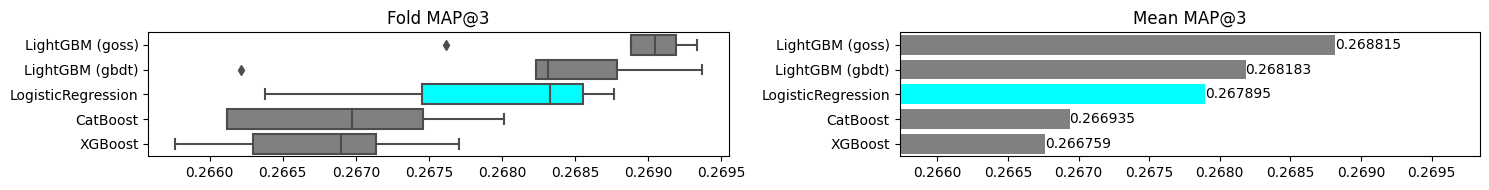

In [17]:
scores = pd.DataFrame(scores)
mean_scores = scores.mean().sort_values(ascending=False)
order = scores.mean().sort_values(ascending=False).index.tolist()

min_score = mean_scores.min()
max_score = mean_scores.max()
padding = (max_score - min_score) * 0.5
lower_limit = min_score - padding
upper_limit = max_score + padding

fig, axs = plt.subplots(1, 2, figsize=(15, scores.shape[1] * 0.4))

boxplot = sns.boxplot(data=scores, order=order, ax=axs[0], orient="h", color="grey")
axs[0].set_title(f"Fold MAP@3")
axs[0].set_xlabel("")
axs[0].set_ylabel("")

barplot = sns.barplot(x=mean_scores.values, y=mean_scores.index, ax=axs[1], color="grey")
axs[1].set_title(f"Mean MAP@3")
axs[1].set_xlabel("")
axs[1].set_xlim(left=lower_limit, right=upper_limit)
axs[1].set_ylabel("")

for i, (score, model) in enumerate(zip(mean_scores.values, mean_scores.index)):
    color = "cyan" if "logistic" in model.lower() else "grey"
    barplot.patches[i].set_facecolor(color)
    boxplot.patches[i].set_facecolor(color)
    barplot.text(score, i, round(score, 6), va="center")

plt.tight_layout()
plt.show()